In [2]:
# Libraries
import pandas as pd
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, OpenAI, PartOfSpeech
from bertopic.vectorizers import ClassTfidfTransformer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer
import re
from io import StringIO
import matplotlib.pyplot as plt
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
import spacy
from keybert import KeyBERT
import pickle
import seaborn as sns

c:\Users\alber\anaconda3\envs\bertopic\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
import bertopic
bertopic.__version__

'0.16.2'

In [7]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alber\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\alber\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [8]:
# Define additional words to remove, including 'nan' for empty cells
custom_words_to_remove = ['nan']

# Function to preprocess text
def preprocess_text(text):
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords and additional custom words
    words_filtered = [word for word in tokens if word not in custom_words_to_remove]
    return " ".join(words_filtered)

In [9]:
# Preprocess the Dataset

# Define the path to your original CSV file
file_path = r'C:\Users\alber\Desktop\BERTopic\filtered_output.csv'

# Read the CSV file as a text string and correct the header
with open(file_path, 'r', encoding='utf-8') as file:
    file_content = file.read()
lines = file_content.splitlines()
if lines and ',' not in lines[2][-1]:
    lines[2] += ','  # Add a comma to the end of the header row
corrected_content = '\n'.join(lines)
corrected_file = StringIO(corrected_content)

# Load the corrected content into a pandas DataFrame
df = pd.read_csv(corrected_file, sep=',', header=2)

# Combine 'Title - DWPI' and 'Abstract - DWPI', with fallback to 'Title' and 'Abstract'
df['text'] = df.apply(lambda row: row['Title - DWPI'] if pd.notnull(row['Title - DWPI']) and row['Title - DWPI'].strip() else row['Title'], axis=1).astype(str) + " " + df.apply(lambda row: row['Abstract - DWPI'] if pd.notnull(row['Abstract - DWPI']) and row['Abstract - DWPI'].strip() else row['Abstract'], axis=1).astype(str)

# Apply text preprocessing with lemmatization
df['clean_text'] = df['text'].apply(preprocess_text)

# Prepare the timestamps and filter out NaN values
df['Publication Date'] = pd.to_datetime(df['Publication Date'], format='%Y-%m-%d', errors='coerce')
df = df.dropna(subset=['Publication Date'])  # Drop rows where 'Publication Date' is NaT/NaN (7 missing rows)
timestamps = df['Publication Date'].tolist()

In [10]:
df.shape

(14241, 18)

In [11]:
print(df['clean_text'].head())

0    User notification method in centralized monito...
1    Programming of cellular set over control chann...
2    Location indication determining method for use...
3    Alarm system e.g . for vehicle provides proxim...
4    Electrically powered security system for monit...
Name: clean_text, dtype: object


In [8]:
# Pre-calculate embeddings
embedding_model = SentenceTransformer('AI-Growth-Lab/PatentSBERTa')
embeddings = embedding_model.encode(df['clean_text'].to_list(), show_progress_bar=True)

Batches: 100%|██████████| 446/446 [3:35:32<00:00, 29.00s/it]  


In [13]:
# Load this if only load you don't recalculate embeddings
embedding_model = SentenceTransformer('AI-Growth-Lab/PatentSBERTa')

In [9]:
# Save embeddings to a pickle file
with open('embeddings_new.pkl', 'wb') as file:
    pickle.dump(embeddings, file)

In [14]:
# Load embeddings from a pickle file
with open('embeddings_new.pkl', 'rb') as file:
    embeddings = pickle.load(file)

In [15]:
umap_model = UMAP(n_neighbors=10, n_components=10, min_dist=0.0, metric='cosine', random_state=42)

In [16]:
hdbscan_model = HDBSCAN(min_cluster_size=100, min_samples=10,
                        metric='euclidean',
                        cluster_selection_method='eom',
                        gen_min_span_tree=True,
                        prediction_data=True)

In [17]:
stopwords = list(stopwords.words('english')) + ['http', 'https', 'amp', 'com', 'thereof']
vectorizer_model = CountVectorizer(stop_words=stopwords, min_df=1, ngram_range=(1, 2))

In [18]:
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)

In [19]:
# KeyBERT
keybert_model = KeyBERTInspired()

# Part-of-Speech
pos_model = PartOfSpeech("en_core_web_sm")

# MMR
mmr_model = MaximalMarginalRelevance(diversity=0.3)

# GPT-3.5
prompt = """
I have a topic that contains the following documents:
[DOCUMENTS]
The topic is described by the following keywords: [KEYWORDS]

Based on the information above, extract a short but highly descriptive topic label of at most 5 words. Make sure it is in the following format:
topic: <topic label>
"""
#client = openai.OpenAI(api_key="sk-...")
#openai_model = OpenAI(client, model="gpt-3.5-turbo", exponential_backoff=True, chat=True, prompt=prompt)

# All representation models
representation_model = {
    "KeyBERT": keybert_model,
    # "OpenAI": openai_model,  # Uncomment if you will use OpenAI
    "MMR": mmr_model,
    "POS": pos_model
}

In [20]:
zeroshot_topic_list = ["autonomous vehicle", "display screen user interface", "traffic navigation", "ridesharing optimization"]

In [21]:
topic_model = BERTopic(
  # Pipeline models
  embedding_model=embedding_model,
  ctfidf_model=ctfidf_model,
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
  vectorizer_model=vectorizer_model,
  representation_model=representation_model,
  zeroshot_topic_list=zeroshot_topic_list,
  nr_topics="auto",
  zeroshot_min_similarity=.3,
  verbose=True
)

topics, _ = topic_model.fit_transform(df['clean_text'].to_list(), embeddings)

2024-06-11 06:48:48,642 - BERTopic - Zeroshot Step 1 - Finding documents that could be assigned to either one of the zero-shot topics
2024-06-11 06:48:50,909 - BERTopic - Zeroshot Step 1 - Completed ✓
2024-06-11 06:48:50,910 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-06-11 06:48:59,315 - BERTopic - Dimensionality - Completed ✓
2024-06-11 06:48:59,316 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-06-11 06:48:59,349 - BERTopic - Cluster - Completed ✓
2024-06-11 06:48:59,350 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-06-11 06:49:28,215 - BERTopic - Representation - Completed ✓
2024-06-11 06:49:28,235 - BERTopic - Topic reduction - Reducing number of topics
2024-06-11 06:49:56,711 - BERTopic - Topic reduction - Reduced number of topics from 4 to 4
2024-06-11 06:49:56,966 - BERTopic - Zeroshot Step 2 - Clustering documents that were not found in the zero-shot model...
2024-06-11

In [22]:
# After fitting, update topic representations
topic_model.update_topics(df['clean_text'].to_list(), vectorizer_model=vectorizer_model, )

In [24]:
# Create a dictionary for renaming topics
new_topic_names = {
    0: "Topic 1 - Autonomous Vehicle",
    1: "Topic 2 - Display Screen and User Interface",
    2: "Topic 3 - Traffic Navigation",
    3: "Topic 4 - Ridesharing Optimization",
    4: "Topic 5 - Optical Systems and Laser Technology",
    5: "Topic 6 - Wireless Communication Device"
}

# Set the new topic labels
topic_model.set_topic_labels(new_topic_names)

In [25]:
# Step 2: Transform the documents to get the topic probabilities
_, probs = topic_model.transform(df['clean_text'].to_list(), embeddings)

# Calculate and visualize the topics over time
topics_over_time = topic_model.topics_over_time(df['clean_text'].to_list(), timestamps, global_tuning=True, evolution_tuning=True, nr_bins=50)

# Visualize the topics over time
topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=10, custom_labels=True)

2024-06-11 06:51:41,102 - BERTopic - Predicting topic assignments through cosine similarity of topic and document embeddings.
48it [02:38,  3.30s/it]


In [26]:
# New: Utilize additional visualization methods
topic_model.visualize_barchart(top_n_topics=10)

In [27]:
topic_model.visualize_term_rank()

In [28]:
topic_model.visualize_heatmap(n_clusters=4, custom_labels=True)

In [29]:
topic_model.visualize_topics()

In [42]:
# %% [code]
# Convert the topics_over_time DataFrame to a CSV file and save it in the current working directory
topics_over_time.to_csv("topics_over_time.csv", index=False)

In [30]:
# %% [code]
# Preview of topics
topic_model.get_topic_info()

,Topic,Count,Name,CustomName,Representation,KeyBERT,MMR,POS,Representative_Docs
0,-1,418,-1_data_method_system_computer,-1_data_method_system_computer,"[data, method, system, computer, involves, set...",NaN,NaN,NaN,NaN
1,0,5137,0_vehicle_system_autonomous_data,Topic 1 - Autonomous Vehicle,"[vehicle, system, autonomous, data, method, au...","[autonomous vehicle, autonomous vehicles, auto...","[vehicle, autonomous, system, autonomous vehic...","[vehicle, autonomous, system, autonomous vehic...",[Method for monitoring and evaluating vehicle ...
2,1,3962,1_user_device_display_method,Topic 2 - Display Screen and User Interface,"[user, device, display, method, interface, sys...","[computing device, electronic device, device, ...","[display, user, device, interface, user interf...","[display, user, device, interface, screen, com...",[Network computer system for generating and pr...
3,2,2555,2_route_system_information_location,Topic 3 - Traffic Navigation,"[route, system, information, location, method,...","[navigation system, traffic information, trans...","[route, traffic, navigation, information, loca...","[route, traffic, navigation, information, loca...",[Network system for managing network service o...
4,3,1766,3_service_system_location_method,Topic 4 - Ridesharing Optimization,"[service, system, location, method, user, devi...","[transport service, transport, ridesharing, tr...","[service, location, method, user, system, tran...","[service, location, method, user, system, tran...",[Transport arrangement method for fleet manage...
5,4,268,4_image_optical_light_laser,Topic 5 - Optical Systems and Laser Technology,"[image, optical, light, laser, images, portion...","[data processing, method, method involves, com...","[data, method, system, computer, set, involves...","[data, method, system, computer, set, network,...",[Directing cells to differentiate along a meso...
6,5,135,5_wireless_device_communication_mobile,Topic 6 - Wireless Communication Device,"[wireless, device, communication, mobile, loca...","[optical, optical fiber, lidar, sensor, laser,...","[image, light, optical, images, laser, portion...","[image, light, optical, images, laser, portion...",[Method for assessing quality of set of change...


In [44]:
# Extract C-TF-IDF scores and words
c_tf_idf = topic_model.c_tf_idf_
words = topic_model.get_topic_info()

# Convert C-TF-IDF scores to a DataFrame
c_tf_idf_df = pd.DataFrame(c_tf_idf.toarray(), columns=topic_model.vectorizer_model.get_feature_names_out())

# Save the C-TF-IDF scores DataFrame to a CSV file
c_tf_idf_df.to_csv('c_tf_idf_scores.csv', index=False)

# Extract the topic words and their scores
topic_words = topic_model.get_topics()

# Convert the topic words and scores to a DataFrame
all_topic_words = []
for topic_num, word_list in topic_words.items():
    for word, score in word_list:
        all_topic_words.append((topic_num, word, score))

df_topic_words = pd.DataFrame(all_topic_words, columns=['Topic', 'Word', 'Score'])

# Save the topic words and scores DataFrame to a CSV file
df_topic_words.to_csv('topic_words_scores.csv', index=False)


In [31]:
# %% [code]
# Visualize the hierarchy
topic_model.visualize_hierarchy(top_n_topics=20, custom_labels=True)  # Adjust `top_n_topics` as needed

In [34]:
import pandas as pd

# Load the alias mapping file
alias_mapping = pd.read_csv(r'C:\Users\alber\Desktop\BERTopic/Assignee alias.txt', sep='\t', header=None, names=['original', 'alias'])

# Convert alias_mapping to lowercase for consistency
alias_mapping['original'] = alias_mapping['original'].str.lower()
alias_mapping['alias'] = alias_mapping['alias'].str.lower()

# Assuming 'df' and 'topics' are already defined in your environment
# Create a DataFrame to map documents to their topics using Publication Number and Optimized Assignee
df_mapping = pd.DataFrame({
    "publication_number": df['Publication Number'],
    "optimized_assignee": df['Optimized Assignee'].str.lower(),  # Convert to lowercase
    "document": df['text'],
    "clean_text": df['clean_text'],
    "topic": topics
})

# Create a dictionary from the alias mapping for faster lookup
alias_dict = dict(zip(alias_mapping['original'], alias_mapping['alias']))

# Function to split and expand rows
def expand_assignees(row):
    assignees = [assignee.strip() for assignee in row['optimized_assignee'].split('|')]
    return pd.DataFrame({
        'publication_number': [row['publication_number']] * len(assignees),
        'optimized_assignee': assignees,
        'document': [row['document']] * len(assignees),
        'clean_text': [row['clean_text']] * len(assignees),
        'topic': [row['topic']] * len(assignees)
    })

# Apply the function to the DataFrame and concatenate the results
expanded_df = pd.concat(df_mapping.apply(expand_assignees, axis=1).tolist(), ignore_index=True)

# Apply the alias mapping to the expanded DataFrame
expanded_df['optimized_assignee'] = expanded_df['optimized_assignee'].map(alias_dict).fillna(expanded_df['optimized_assignee'])

# Save the mapping to a CSV file for further analysis
expanded_df.to_csv("document_topic_mapping.csv", index=False)

# Display the first few rows of the expanded DataFrame
print(expanded_df.head())

  publication_number                 optimized_assignee  \
0        US7489921B2         samsung electronics co ltd   
1         US6044265A                    bellsouth corp.   
2        US6912545B1                boost worldwide llc   
3        US6912545B1  sprint international incorporated   
4        US6912545B1                      sprintcom llc   

                                            document  \
0  User notification method in centralized monito...   
1  Programming of cellular set over control chann...   
2  Location indication determining method for use...   
3  Location indication determining method for use...   
4  Location indication determining method for use...   

                                          clean_text  topic  
0  User notification method in centralized monito...      0  
1  Programming of cellular set over control chann...      3  
2  Location indication determining method for use...      2  
3  Location indication determining method for use...      2 

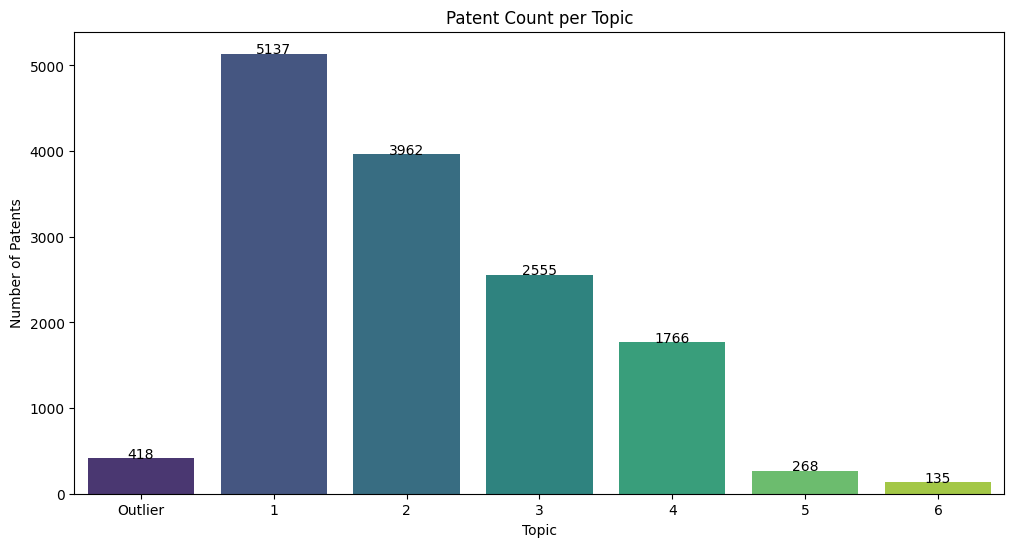

In [58]:
# Count the number of documents per topic
topic_counts = df_mapping['topic'].value_counts().sort_index().reset_index()
topic_counts.columns = ['topic', 'count']

# Define a color palette
palette = sns.color_palette("viridis", len(topic_counts))

# Plot the document count for each topic
plt.figure(figsize=(12, 6))
barplot = sns.barplot(x='topic', y='count', data=topic_counts, palette=palette)
plt.xlabel('Topic')
plt.ylabel('Number of Patents')
plt.title('Patent Count per Topic')

# Annotate each bar with the count
for index, row in topic_counts.iterrows():
    barplot.text(index, row['count'], row['count'], color='black', ha="center")

# Rename the x-axis labels
new_labels = ['Outlier', '1', '2', '3', '4', '5', '6']
barplot.set_xticklabels(new_labels)

plt.show()

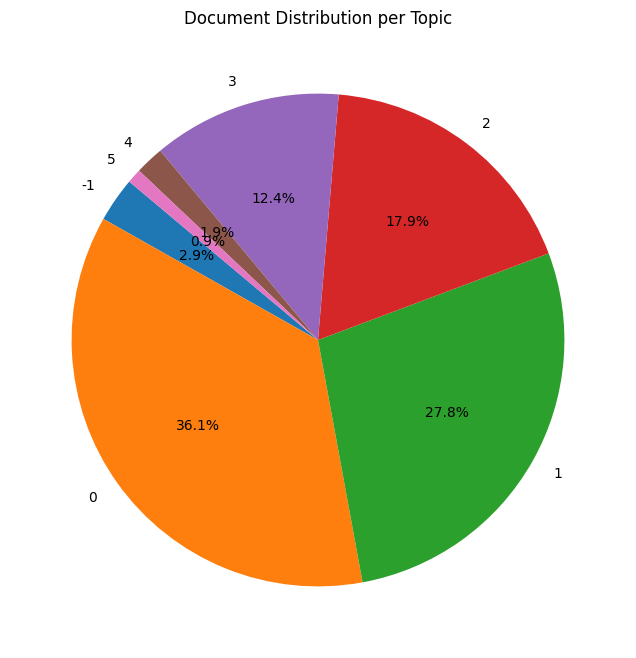

In [49]:
import matplotlib.pyplot as plt

# Count the number of documents per topic
topic_counts = df_mapping['topic'].value_counts().sort_index().reset_index()
topic_counts.columns = ['topic', 'count']

# Plot the document count for each topic as a pie chart
plt.figure(figsize=(10, 8))
plt.pie(topic_counts['count'], labels=topic_counts['topic'], autopct='%1.1f%%', startangle=140)
plt.title('Document Distribution per Topic')
plt.show()

In [50]:
import plotly.express as px

# Reduce dimensionality of embeddings for visualization
umap_2d = UMAP(n_components=2, random_state=42)
embeddings_2d = umap_2d.fit_transform(embeddings)

# Create a DataFrame with 2D embeddings and topic labels
df_embeddings_2d = pd.DataFrame(embeddings_2d, columns=['x', 'y'])
df_embeddings_2d['topic'] = topics

# Plot the 2D embeddings
fig = px.scatter(df_embeddings_2d, x='x', y='y', color='topic', title='Document Clusters')
fig.show()